In [2]:
%matplotlib inline
import os
import torch
from tqdm.notebook import tqdm
import funcs
from matplotlib.container import BarContainer
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline

backend_inline.set_matplotlib_formats('svg')

## 加载数据集

In [3]:
def read_data_nmt(data_path="./data_set/fra-eng/"):
    """载入“英语－法语”数据集"""
    with open(os.path.join(data_path, 'fra.txt'), 'r',
             encoding='utf-8') as f:
        return f.read()

def preprocess_nmt(text:str):
    """文本预处理"""
    # 替换空白字符为普通空格，并转为全小写
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '
    out = [" " + char if k>0 and no_space(char, text[k-1]) else char for k, char in enumerate(tqdm(text))]
    return "".join(out)

In [4]:
raw_text = read_data_nmt()
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



In [5]:
text = preprocess_nmt(raw_text)
print(text[:80])

  0%|          | 0/11489286 [00:00<?, ?it/s]

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


## 词元化
在机器翻译中，更多使用单词级词元化 （最先进的模型可能使用更高级的词元化技术）。

下面的`tokenize_nmt`函数对前`num_examples`个文本序列对进行词元， 其中每个词元要么是一个词，要么是一个标点符号。 此函数返回两个词元列表：`source`和`target`： `source[i]`是源语言（这里是英语）第$i$个文本序列的词元列表， `target[i]`是目标语言（这里是法语）第$i$个文本序列的词元列表。

In [4]:
def tokenize_nmt(text:str, num_examples=None):
    """词元化“英语－法语”数据数据集"""
    source, target = [], []
    for k, line in enumerate(text.split('\n')):
        if (num_examples is not None) and (k > num_examples):
            break
        pair = line.split('\t')
        if len(pair) == 2:
            source.append(pair[0].split(" "))
            target.append(pair[1].split(" "))
    return source, target

In [7]:
s, t = tokenize_nmt(text)
s[:6], "...", t[:6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 '...',
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

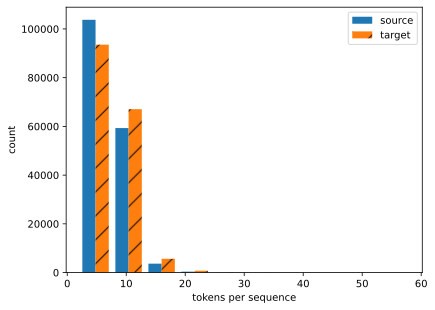

In [8]:
token_nums = [[len(i) for i in s],
              [len(i) for i in t]]
patches:list[BarContainer]
_, _, patches = plt.hist(token_nums)
for patch in patches[1].patches:
        patch.set_hatch('/')
plt.xlabel("tokens per sequence")
plt.ylabel("count")
plt.legend(["source", "target"])

## 词表

`<bos>`表示一个句子的开始。`<eos>`表示句子的结束

In [9]:
src_vocab = funcs.Vocab(s, min_freq=2, 
                        reserved_tokens=["<pad>", '<bos>', "<eos>"])
len(src_vocab)

10012

In [5]:
def truncate_pad(line:list[int], num_steps:int, padding_token:list[str]):
    """截断或填充文本序列
    
    输入参数
    ----------
    `line`     : 输入的句子
    `num_steps`: 需要调整到的长度
    `padding_token` : 长度不足时使用的填充词元
    """
    if len(line) > num_steps:
        return line[:num_steps]
    else:
        return line + [padding_token] * (num_steps - len(line))

In [ ]:
truncate_pad(src_vocab[s[0]], 10, src_vocab['<pad>'])

In [6]:
def build_array_nmt(lines:list, vocab:funcs.Vocab, num_steps:int):
    """将文本序列转换为小批量"""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor(
        [truncate_pad(l, num_steps, vocab["<pad>"]) for l in lines]
        )
    valid_len = (array != vocab["<pad>"]).to(torch.int32).sum(1)
    return array, valid_len

In [ ]:
build_array_nmt(s[:5], src_vocab, 5)

# 训练模型准备
- 机器翻译指的是将文本序列从一种语言自动翻译成另一种语言。
- 使用单词级词元化时的词表大小，将明显大于使用字符级词元化时的词表大小。为了缓解这一问题，我们可以将低频词元视为相同的未知词元。
- 通过截断和填充文本序列，可以保证所有的文本序列都具有相同的长度，以便以小批量的方式加载。

In [7]:
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """返回翻译数据集迭代器及词表
    
    """
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    reserved_tokens = ['<pad>', "<bos>", "<eos>"]
    src_vocab = funcs.Vocab(source, 2, reserved_tokens)
    tgt_vocab = funcs.Vocab(target, 2, reserved_tokens)
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    
    dataset = torch.utils.data.TensorDataset(*data_arrays)
    data_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    return data_iter, src_vocab, tgt_vocab

In [8]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=5, num_examples=6000)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', X.type(torch.int32))
    print('X的有效长度:', X_valid_len)
    print('Y:', Y.type(torch.int32))
    print('Y的有效长度:', Y_valid_len)
    break

  0%|          | 0/11489286 [00:00<?, ?it/s]

X: tensor([[  9,  16, 160,   4,   3],
        [  5,  93, 268,   4,   3]], dtype=torch.int32)
X的有效长度: tensor([5, 5])
Y: tensor([[  78,  828,    4,    3,    1],
        [  10, 1015,  606,    4,    3]], dtype=torch.int32)
Y的有效长度: tensor([4, 5])


In [9]:
for batch in X:
    for i in batch:
        print(src_vocab.idx_to_token[int(i)], end=" ")
    print()
print("--------")
for batch in Y:
    for i in batch:
        print(tgt_vocab.idx_to_token[int(i)], end=" ")
    print()

you go first . <eos> 
i made these . <eos> 
--------
toi d'abord . <eos> <pad> 
j'ai confectionné ceux-ci . <eos> 


In [11]:
bos =torch.tensor([tgt_vocab["<bos>"]] * Y.shape[0]).reshape(-1,1)
dec_input = torch.cat((bos, Y[:, :-1]), 1)

for batch in dec_input:
    for i in batch:
        print(tgt_vocab.idx_to_token[int(i)], end=" ")
    print()

<bos> toi d'abord . <eos> 
<bos> j'ai confectionné ceux-ci . 
